<a href="https://colab.research.google.com/github/ankitcsr/image_segmentation/blob/master/Gland_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/download/warwick_qu_dataset_released_2016_07_08.zip --output warwick_qu_dataset_released_2016_07_08.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  172M  100  172M    0     0  18.3M      0  0:00:09  0:00:09 --:--:-- 18.4M


In [2]:
!ls

sample_data  warwick_qu_dataset_released_2016_07_08.zip


In [3]:
!unzip  warwick_qu_dataset_released_2016_07_08.zip

Archive:  warwick_qu_dataset_released_2016_07_08.zip
   creating: Warwick QU Dataset (Released 2016_07_08)/
  inflating: Warwick QU Dataset (Released 2016_07_08)/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/Warwick QU Dataset (Released 2016_07_08)/
  inflating: __MACOSX/Warwick QU Dataset (Released 2016_07_08)/._.DS_Store  
  inflating: Warwick QU Dataset (Released 2016_07_08)/Grade.csv  
  inflating: __MACOSX/Warwick QU Dataset (Released 2016_07_08)/._Grade.csv  
  inflating: Warwick QU Dataset (Released 2016_07_08)/testA_1.bmp  
  inflating: __MACOSX/Warwick QU Dataset (Released 2016_07_08)/._testA_1.bmp  
  inflating: Warwick QU Dataset (Released 2016_07_08)/testA_10.bmp  
  inflating: __MACOSX/Warwick QU Dataset (Released 2016_07_08)/._testA_10.bmp  
  inflating: Warwick QU Dataset (Released 2016_07_08)/testA_10_anno.bmp  
  inflating: __MACOSX/Warwick QU Dataset (Released 2016_07_08)/._testA_10_anno.bmp  
  inflating: Warwick QU Dataset (Released 2016_07_08)/testA_11.b

In [4]:
!ls


 __MACOSX     'Warwick QU Dataset (Released 2016_07_08)'
 sample_data   warwick_qu_dataset_released_2016_07_08.zip


In [5]:
cd 'Warwick QU Dataset (Released 2016_07_08)'

/content/Warwick QU Dataset (Released 2016_07_08)


In [0]:
import pandas as pd
from PIL import Image


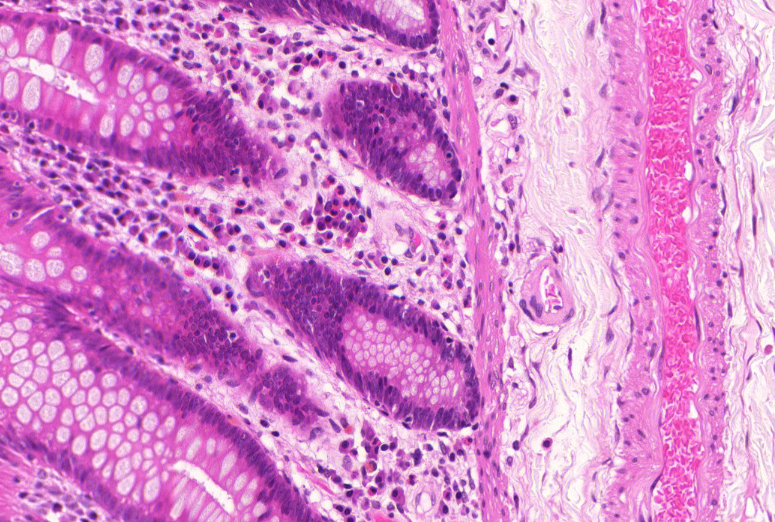

In [7]:
Image.open('train_2.bmp')

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread,imshow
from PIL import Image
import torch
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [9]:
data=pd.read_csv('Grade.csv')
len(data)

165

In [0]:
class Train_dataset(Dataset):
    def __init__(self,csv_path,transform_img):
        self.data=pd.read_csv(csv_path)
        self.train_data=self.data[self.data.name.str.match('train*')]
        self.transform_img=transform_img
    def __len__(self):
        return len(self.train_data)

    def __getitem__(self,index):
        image_name=self.train_data.name.iloc[index]+'.bmp'
        image=Image.open(image_name)
        image=self.transform_img(image)
        label_name=self.train_data[' grade (GlaS)'].iloc[0]
        label=  1 if label_name == " malignant" else 0
        return [image,label]
    

In [0]:
class Valid_dataset(Dataset):
    def __init__(self,csv_path,transform_img):
        self.data=pd.read_csv(csv_path)
        self.train_data=self.data[self.data.name.str.match('testA*')]
        self.transform_img=transform_img
    
    def __len__(self):
        return len(self.train_data)

    def __getitem__(self, index):
        image_name=self.train_data.name.iloc[index]+'.bmp'
        image=Image.open(image_name)
        image=self.transform_img(image)
        label_name=self.train_data[' grade (GlaS)'].iloc[0]
        label=  1 if label_name == " malignant" else 0
        return [image,label]
    

In [0]:
class Test_dataset(Dataset):
    def __init__(self,csv_path,transform_img):
        self.data=pd.read_csv(csv_path)
        self.train_data=self.data[self.data.name.str.match('testB*')]
        self.transform_img=transform_img
    
    def __len__(self):
        return len(self.train_data)

    def __getitem__(self, index):
        image_name=self.train_data.name.iloc[index]+'.bmp'
        image=Image.open(image_name)
        image=self.transform_img(image)
        label_name=self.train_data[' grade (GlaS)'].iloc[0]
        label=  1 if label_name == " malignant" else 0
        return [image,label]
    


In [0]:
from torchvision import transforms

In [0]:
transform_img=transforms.Compose([
    transforms.Resize((250,250)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.ColorJitter()
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [0]:
transform_test=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [0]:
train_dataset=Train_dataset('Grade.csv',transform_img)
valid_dataset=Valid_dataset('Grade.csv',transform_img)
test_dataset=Test_dataset('Grade.csv',transform_test)

In [0]:
params = {'batch_size': 1,'shuffle': True}
max_epochs = 10

training_generator = DataLoader(train_dataset, **params)
valid_generator = DataLoader(valid_dataset, **params)
test_generator = DataLoader(test_dataset, **params)

In [0]:

#for local_batch, local_labels in valid_generator:
        

In [0]:
import torchvision.models as models


In [19]:
resnet18 = models.resnet18(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 25348962.22it/s]


In [0]:
import torch.nn as nn

In [0]:
resnet18.fc=nn.Linear(in_features=512, out_features=2, bias=True)

In [0]:
model=resnet18

In [0]:
model=model.to(device)

In [24]:
for name,param in model.named_parameters():
    if param.requires_grad == True:
        print(name)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

In [0]:
#for name,param in list(model.named_parameters())[-8:]:
#    param.requires_grad = False

In [0]:
#for name,param in model.named_parameters():
#    if param.requires_grad == True:
#        print(name)

In [0]:
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

In [0]:
import torch.optim as optim
import  torch.nn.functional as F

In [0]:
import time
import copy


In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_loss_history = []
    train_loss_history= []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss_so_far = 9999999999
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()


            print('{} Loss: {:.4f} '.format(phase, loss))

            # deep copy the model
            if phase == 'val' and loss < best_loss_so_far:
                best_loss_so_far=loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss_history.append(loss)
            if phase =='train':
                with torch.no_grad(): 
                    train_loss_history.append(loss)
                

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best loss in validation set : {:4f}'.format(best_loss_so_far))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_loss_history,train_loss_history

In [31]:
dataloaders={'train':training_generator,'val':valid_generator}
optimizer = optim.Adam(params_to_update,lr=1e-7)
criterion = nn.CrossEntropyLoss()

num_epochs=10
model_classification,v_hist,t_hist=train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 0.8864 
val Loss: 0.5020 

Epoch 1/9
----------
train Loss: 0.8909 
val Loss: 0.4084 

Epoch 2/9
----------
train Loss: 0.9099 
val Loss: 0.9914 

Epoch 3/9
----------
train Loss: 0.9026 
val Loss: 0.4153 

Epoch 4/9
----------
train Loss: 0.8536 
val Loss: 0.3545 

Epoch 5/9
----------
train Loss: 0.8567 
val Loss: 1.1706 

Epoch 6/9
----------
train Loss: 0.8626 
val Loss: 0.5457 

Epoch 7/9
----------
train Loss: 0.8508 
val Loss: 0.5357 

Epoch 8/9
----------
train Loss: 0.8552 
val Loss: 0.3701 

Epoch 9/9
----------
train Loss: 0.8693 
val Loss: 0.3822 

Training complete in 0m 37s
Best loss in validation set : 0.354470


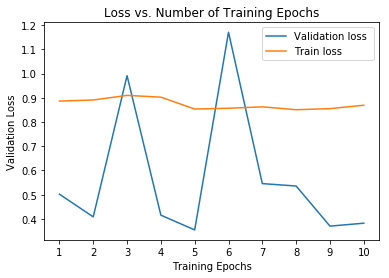

In [32]:
vhist = []

vhist = [h.cpu().numpy() for h in v_hist]
thist = []

thist = [h.cpu().detach().numpy() for h in t_hist]

plt.title("Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Loss")
plt.plot(range(1,num_epochs+1),vhist,label="Validation loss ")
plt.plot(range(1,num_epochs+1),thist,label="Train loss")

plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [0]:
#segmentation

In [0]:
import torch
import torch.nn as nn
from torchvision import models

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [0]:
def dice_loss(pred, target):
    smooth = 1.

    # have to use contiguous since they may from a torch.view op
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(iflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    
    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

        

In [0]:
model_seg = ResNetUNet(n_class=1)
model_seg=model_seg.to(device)

In [0]:
class my_sigmoid_layer(nn.Module):
    def __init__(self,):
        super(my_sigmoid_layer,self).__init__()
    def forward(self,input):
        return F.sigmoid(input) 
    
last_layer=my_sigmoid_layer()   
model_seg = nn.Sequential(model_seg,last_layer)

In [0]:
class Train_dataset_seg(Dataset):
    def __init__(self,csv_path,transform_img,transform_target):
        self.data=pd.read_csv(csv_path)
        self.train_data=self.data[self.data.name.str.match('train*')]
        self.transform_img=transform_img
        self.transform_target=transform_target
    def __len__(self):
        return len(self.train_data)

    def __getitem__(self,index):
        image_name=self.train_data.name.iloc[index]
        image=Image.open(image_name+'.bmp')
        image=self.transform_img(image)
        label=Image.open(image_name+'_anno.bmp')
        label=self.transform_target(label)
        t = torch.Tensor([0]) # threshold
        out = (label > t).float() * 1
        return [image,out]

In [0]:
class Valid_dataset_seg(Dataset):
    def __init__(self,csv_path,transform_img,transform_target):
        self.data=pd.read_csv(csv_path)
        self.train_data=self.data[self.data.name.str.match('testA*')]
        self.transform_img=transform_img
        self.transform_target=transform_target
    def __len__(self):
        return len(self.train_data)

    def __getitem__(self,index):
        image_name=self.train_data.name.iloc[index]
        image=Image.open(image_name+'.bmp')
        image=self.transform_img(image)
        label=Image.open(image_name+'_anno.bmp')
        label=self.transform_target(label)
        t = torch.Tensor([0])  # threshold
        out = (label > t).float() * 1
        return [image,out]

In [0]:
transform_img=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
transform_target=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

In [0]:
train_dataset=Train_dataset_seg('Grade.csv',transform_img,transform_target)
valid_dataset=Valid_dataset_seg('Grade.csv',transform_img,transform_target)

params = {'batch_size': 2,'shuffle': True}

training_generator = DataLoader(train_dataset, **params)
valid_generator = DataLoader(valid_dataset, **params)


In [42]:
pip install torchsummary

In [47]:
from torchsummary import summary
summary(model_seg, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 112, 112]           9,408
            Conv2d-6         [-1, 64, 112, 112]           9,408
       BatchNorm2d-7         [-1, 64, 112, 112]             128
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
             ReLU-10         [-1, 64, 112, 112]               0
        MaxPool2d-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]          36,864
           Conv2d-14           [-1, 64,

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [0]:
def train_model_seg(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_loss_history = []
    train_loss_history= []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss_so_far = 9999999999
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #m = nn.Sigmoid()
                    #outputs = m(outputs)
                    bceLoss=nn.BCELoss()
                    loss = criterion(outputs, labels)+bceLoss(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()


            print('{} Loss: {:.4f} '.format(phase, loss))

            # deep copy the model
            if phase == 'val' and loss < best_loss_so_far:
                best_loss_so_far=loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss_history.append(loss)
            if phase =='train':
                with torch.no_grad(): 
                    train_loss_history.append(loss)
                

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best loss in validation set : {:4f}'.format(best_loss_so_far))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_loss_history,train_loss_history

In [0]:
params_to_update = []
for name,param in model_seg.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

In [56]:
dataloaders={'train':training_generator,'val':valid_generator}
optimizer = optim.Adam(params_to_update,lr=1e-4)
criterion = dice_loss # + bce loss in model_seg loss calculation
num_epochs=1
model_best,v_hist,t_hist=train_model_seg(model_seg, dataloaders, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/0
----------


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train Loss: 0.1151 
val Loss: 0.8270 

Training complete in 0m 13s
Best loss in validation set : 0.827036


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


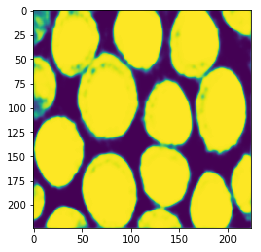

In [60]:

for inputs, labels in valid_generator:
    inputs=inputs.to(device)
    
    output=model_best(inputs).cpu()
    output=output.detach().numpy()
    #m = nn.Sigmoid()
    #output = m(output)
    #output=output*255
    #t = torch.Tensor([0])  # threshold
    #out = (output[0] > t).float() * 255
    img = np.transpose(output[0], (1,2,0))
    img=img.squeeze()
    plt.imshow(img)
    plt.show()
    break

#annotation on validation set

In [0]:
#output[0]

In [0]:
vhist = []

vhist = [h.cpu().numpy() for h in v_hist]
thist = []

thist = [h.cpu().detach().numpy() for h in t_hist]

plt.title("Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Loss")
plt.plot(range(1,num_epochs+1),vhist,label="Validation loss ")
plt.plot(range(1,num_epochs+1),thist,label="Train loss")

plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

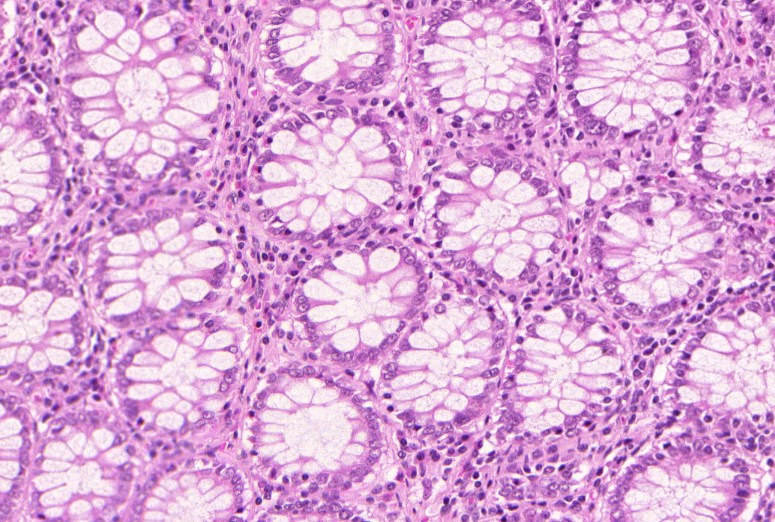

In [62]:
Image.open('testA_5.bmp')

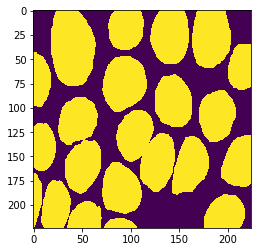

In [63]:
#original annotation  for testA_5
image_name='testA_5_anno'
image=Image.open(image_name+'.bmp')
label=transform_target(image)
t = torch.Tensor([0])  # threshold
out = (label > t).float() * 255
img = np.transpose(out, (1,2,0))
img=img.squeeze()
plt.imshow(img)
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


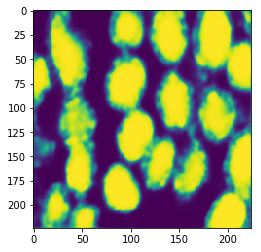

In [66]:
image_name='testA_5'
image=Image.open(image_name+'.bmp')
image=transform_img(image)
image=image.unsqueeze(0)
image=image.to(device)
output=model_best(image)
output=output.cpu()
output=output.detach().numpy()
#m = nn.Sigmoid()
#output = m(output)
#output=output*255
#t = torch.Tensor([0])  # threshold
#out = (output[0] > t).float() * 255
img = np.transpose(output[0], (1,2,0))
img=img.squeeze()
plt.imshow(img)
plt.show()
#predicted testA_5 annotation without thresholding

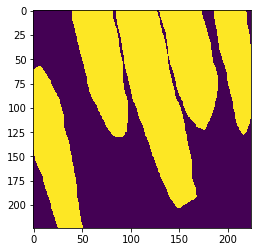

In [70]:
#original annotation  for testA_20
image_name='testA_20_anno'
image=Image.open(image_name+'.bmp')
label=transform_target(image)
t = torch.Tensor([0])  # threshold
out = (label > t).float() * 255
img = np.transpose(out, (1,2,0))
img=img.squeeze()
plt.imshow(img)
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


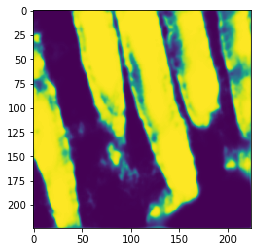

In [71]:
image_name='testA_20'
image=Image.open(image_name+'.bmp')
image=transform_img(image)
image=image.unsqueeze(0)
image=image.to(device)
output=model_best(image)
output=output.cpu()
output=output.detach().numpy()
#m = nn.Sigmoid()
#output = m(output)
#output=output*255
#t = torch.Tensor([0])  # threshold
#out = (output[0] > t).float() * 255
img = np.transpose(output[0], (1,2,0))
img=img.squeeze()
plt.imshow(img)
plt.show()
#predicted testA_20 annotation without thresholding

In [0]:
#above examples are output on validation(not used in training) set after 15 epchoes on only train data(85 images) ) results can be much improved if more trained with hyperparameter tuning 